# Прогнозирование оттока клиентов оператора «ТелеДом»

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. **Цель исследования** - построить модель, которая будет предсказывать, разорвёт ли абонент договор, используя персональные данные о некоторых клиентах и информацию об их тарифах и услугах.

**План работы:**
- Загурзка и предобработка данных
- Объединение данных (генерация дополнительных признаков, выделение целевой переменной)
- Исследовательский анализ данных (проверка корреляции, анализ распределений)
- Подготовка данных
- Обучение моделей
- Выбор и тестирование лучшей модели
- Анализ важности признаков
- Выводы и рекомендации Заказчику

In [1]:
import numpy as np
import pandas as pd

import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostClassifier

import stringcase

import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 300625
TEST_SIZE = 0.25

## Загрузка и предобработка данных

In [3]:
def read_csv_wrap(
    basename
):
    df = pd.read_csv(f'{basename}.csv', index_col='customerID')
    
    # snake case
    df.index.name = 'customer_id'
    df.columns = map(stringcase.snakecase, df.columns)
    
    # name
    df.name = basename.replace('_new', '')
    
    display(df.info())
    display(df.head())
    
    return df

### contract

In [4]:
contract = read_csv_wrap('contract_new')

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
# тип для дат
contract.begin_date = pd.to_datetime(contract.begin_date)
contract.end_date = pd.to_datetime(contract.end_date, errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 440.2+ KB


/tmp/ipykernel_13666/838974099.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract.end_date = pd.to_datetime(contract.end_date, errors='coerce')


In [6]:
# заглушка даты окончания для активных договоров
contract.end_date.fillna(pd.to_datetime('2020-02-01'), inplace=True)
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 440.2+ KB


/tmp/ipykernel_13666/2278290044.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract.end_date.fillna(pd.to_datetime('2020-02-01'), inplace=True)


In [7]:
# электронный расчётный лист в булев
print(contract.paperless_billing.unique())
contract.paperless_billing = contract.paperless_billing.apply(lambda x: x == 'Yes')

['Yes' 'No']


In [8]:
# total_charges в float
contract.total_charges = contract.total_charges.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   bool          
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
dtypes: bool(1), datetime64[ns](2), float64(2), object(2)
memory usage: 392.0+ KB


In [10]:
contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1960.60
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.70,353.50


### personal

In [11]:
personal = read_csv_wrap('personal_new')

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [12]:
# пенсионер в булев
print(personal.senior_citizen.unique())
personal.senior_citizen = personal.senior_citizen.apply(lambda x: x == 1)

[0 1]


In [13]:
# семейное положение в булев
print(personal.partner.unique())
personal.partner = personal.partner.apply(lambda x: x == 'Yes')

['Yes' 'No']


In [14]:
# наличие детей в булев
print(personal.dependents.unique())
personal.dependents = personal.dependents.apply(lambda x: x == 'Yes')

['No' 'Yes']


In [15]:
# пол в булев
print(personal.gender.unique())
personal['is_male'] = personal.gender == 'Male'

['Female' 'Male']


In [16]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   bool  
 2   partner         7043 non-null   bool  
 3   dependents      7043 non-null   bool  
 4   is_male         7043 non-null   bool  
dtypes: bool(4), object(1)
memory usage: 137.6+ KB


In [17]:
personal.head()

,gender,senior_citizen,partner,dependents,is_male
customer_id,,,,,
7590-VHVEG,Female,False,True,False,False
5575-GNVDE,Male,False,False,False,True
3668-QPYBK,Male,False,False,False,True
7795-CFOCW,Male,False,False,False,True
9237-HQITU,Female,False,False,False,False


### internet

In [18]:
internet = read_csv_wrap('internet_new')

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_t_v      5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [19]:
# починим навание колонки
internet = internet.rename(columns={'streaming_t_v': 'streaming_tv'})

In [20]:
# всё булево по смыcлу в булев тип
for col in internet.columns:
    if col == 'internet_service':
        continue
    print(col, internet[col].unique())
    internet[col] = internet[col].apply(lambda x: x == 'Yes')

online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']


In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   bool  
 2   online_backup      5517 non-null   bool  
 3   device_protection  5517 non-null   bool  
 4   tech_support       5517 non-null   bool  
 5   streaming_tv       5517 non-null   bool  
 6   streaming_movies   5517 non-null   bool  
dtypes: bool(6), object(1)
memory usage: 118.5+ KB


In [22]:
internet.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,False,True,False,False,False,False
5575-GNVDE,DSL,True,False,True,False,False,False
3668-QPYBK,DSL,True,True,False,False,False,False
7795-CFOCW,DSL,True,False,True,True,False,False
9237-HQITU,Fiber optic,False,False,False,False,False,False


### phone

In [23]:
phone = read_csv_wrap('phone_new')

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [24]:
print(phone.multiple_lines.unique())
phone.multiple_lines = phone.multiple_lines.apply(lambda x: x == 'Yes')

['No' 'Yes']


In [25]:
# отметим тех, кто пользуется телефоном.
phone['phone'] = True

In [26]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   multiple_lines  6361 non-null   bool 
 1   phone           6361 non-null   bool 
dtypes: bool(2)
memory usage: 62.1+ KB


In [27]:
phone.head()

,multiple_lines,phone
customer_id,,
5575-GNVDE,False,True
3668-QPYBK,False,True
9237-HQITU,False,True
9305-CDSKC,True,True
1452-KIOVK,True,True


### Итог

- данные загружаются корректно
- нужно поменять типы
- из дат можно вытащить доп. признаки (например, длительность договора)
- есть 11 пропусков в contract, в остальных нет
- много категориальных признаков, потребуется кодирование
- есть пара численных, нужно нормализовать
- размеры у датафреймов разные - точно возникнут пропуски при объединении
- в качестве метки класса подойдёт end_date: есть - 1, нет - 0

## Объединение данных

### Общий датафрейм

In [28]:
data = contract.copy()
for df in personal, internet, phone:
    data = data.join(df, how='outer')

display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   bool          
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   bool          
 9   partner            7043 non-null   bool          
 10  dependents         7043 non-null   bool          
 11  is_male            7043 non-null   bool          
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14

None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,is_male,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-02-01,One year,True,Mailed check,65.6,631.73,Female,False,True,...,False,DSL,False,True,False,True,True,False,False,True
0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,False,Mailed check,59.9,539.10,Male,False,False,...,True,DSL,False,False,False,False,False,True,True,True
0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,73.9,406.45,Male,False,False,...,True,Fiber optic,False,False,True,False,False,False,False,True
0011-IGKFF,2018-12-01,2020-02-01,Month-to-month,True,Electronic check,98.0,1372.00,Male,True,True,...,True,Fiber optic,False,True,True,False,True,True,False,True
0013-EXCHZ,2019-09-01,2020-02-01,Month-to-month,True,Mailed check,83.9,444.67,Female,True,True,...,False,Fiber optic,False,False,False,True,True,False,False,True


### Обработка пропусков

In [29]:
total_count = data.shape[0]
print('колонка           пропуски    доля  тип')
for col in data.columns:
    nan_count = data[col].isna().sum()
    print(f'{col:20} {nan_count:5} {100 * nan_count / total_count:6.1f}%  {data[col].dtype}')

колонка           пропуски    доля  тип
begin_date               0    0.0%  datetime64[ns]
end_date                 0    0.0%  datetime64[ns]
type                     0    0.0%  object
paperless_billing        0    0.0%  bool
payment_method           0    0.0%  object
monthly_charges          0    0.0%  float64
total_charges           11    0.2%  float64
gender                   0    0.0%  object
senior_citizen           0    0.0%  bool
partner                  0    0.0%  bool
dependents               0    0.0%  bool
is_male                  0    0.0%  bool
internet_service      1526   21.7%  object
online_security       1526   21.7%  object
online_backup         1526   21.7%  object
device_protection     1526   21.7%  object
tech_support          1526   21.7%  object
streaming_tv          1526   21.7%  object
streaming_movies      1526   21.7%  object
multiple_lines         682    9.7%  object
phone                  682    9.7%  object


Похоже, пропуски возникли у тех клиентов, которые пользуются либо только интернетом, либо только телефоном. 
Также есть 11 клиентов без данных по total_charges - очень мало, можно удалить.
Остальные заполним залушками 'n/a' для услуг телефон / интернет или False для соответствующих дополнительных услуг.

In [30]:
data.dropna(subset=['total_charges'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   bool          
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   bool          
 9   partner            7032 non-null   bool          
 10  dependents         7032 non-null   bool          
 11  is_male            7032 non-null   bool          
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14

In [31]:
data['internet_service'].fillna('n/a', inplace=True)
data.info()

/tmp/ipykernel_13666/1761843898.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['internet_service'].fillna('n/a', inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   bool          
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   bool          
 9   partner            7032 non-null   bool          
 10  dependents         7032 non-null   bool          
 11  is_male            7032 non-null   bool          
 12  internet_service   7032 non-null   object        
 13  online_security    5512 non-null   object        
 14

In [32]:
data.fillna(False, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   bool          
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   bool          
 9   partner            7032 non-null   bool          
 10  dependents         7032 non-null   bool          
 11  is_male            7032 non-null   bool          
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   bool          
 14

/tmp/ipykernel_13666/2576255914.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(False, inplace=True)


### Генерация дополнительных признаков

In [33]:
# длительность в месяцахот начала контракта до разрыва / текущей даты
data['contract_duration'] = (data.end_date - data.begin_date) / np.timedelta64(1, 'm')

In [34]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-02-01,One year,True,Mailed check,65.6,631.73,Female,False,True,...,DSL,False,True,False,True,True,False,False,True,397440.0
0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,False,Mailed check,59.9,539.10,Male,False,False,...,DSL,False,False,False,False,False,True,True,True,397440.0
0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,73.9,406.45,Male,False,False,...,Fiber optic,False,False,True,False,False,False,False,True,220320.0
0011-IGKFF,2018-12-01,2020-02-01,Month-to-month,True,Electronic check,98.0,1372.00,Male,True,True,...,Fiber optic,False,True,True,False,True,True,False,True,614880.0
0013-EXCHZ,2019-09-01,2020-02-01,Month-to-month,True,Mailed check,83.9,444.67,Female,True,True,...,Fiber optic,False,False,False,True,True,False,False,True,220320.0


### Метка класса

In [35]:
data['target'] = data.end_date != pd.to_datetime('2020-02-01')

In [36]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,contract_duration,target
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-02-01,One year,True,Mailed check,65.6,631.73,Female,False,True,...,False,True,False,True,True,False,False,True,397440.0,False
0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,False,Mailed check,59.9,539.10,Male,False,False,...,False,False,False,False,False,True,True,True,397440.0,False
0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,73.9,406.45,Male,False,False,...,False,False,True,False,False,False,False,True,220320.0,False
0011-IGKFF,2018-12-01,2020-02-01,Month-to-month,True,Electronic check,98.0,1372.00,Male,True,True,...,False,True,True,False,True,True,False,True,614880.0,False
0013-EXCHZ,2019-09-01,2020-02-01,Month-to-month,True,Mailed check,83.9,444.67,Female,True,True,...,False,False,False,True,True,False,False,True,220320.0,False


### Итог
- Объединили датафреймы.
- Убрали 11 записей без total_charge, остальные пропуски заполнили заглушкой.
- Выделили целевую переменную
- Сгенерировали дополнительный признак - длительность контракта

## Исследовательский анализ

### Категориальные признаки

In [37]:
def cat_col_plot(
    x
):
    display(data[x].value_counts())
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x, hue='target')
    plt.title(f'Распределение для {data[x].name}')
    plt.show()

type
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

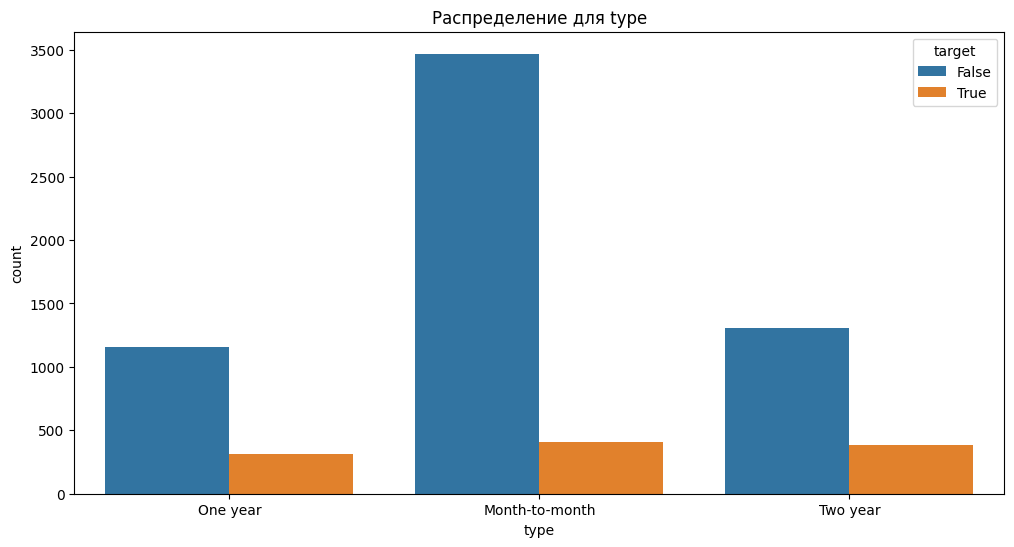

In [38]:
cat_col_plot('type')

3 варианта, можно сделать one-hot.
Можно отметить, что клиенты оплатой раз в год / два года уходят несколько чаще.

paperless_billing
True     4168
False    2864
Name: count, dtype: int64

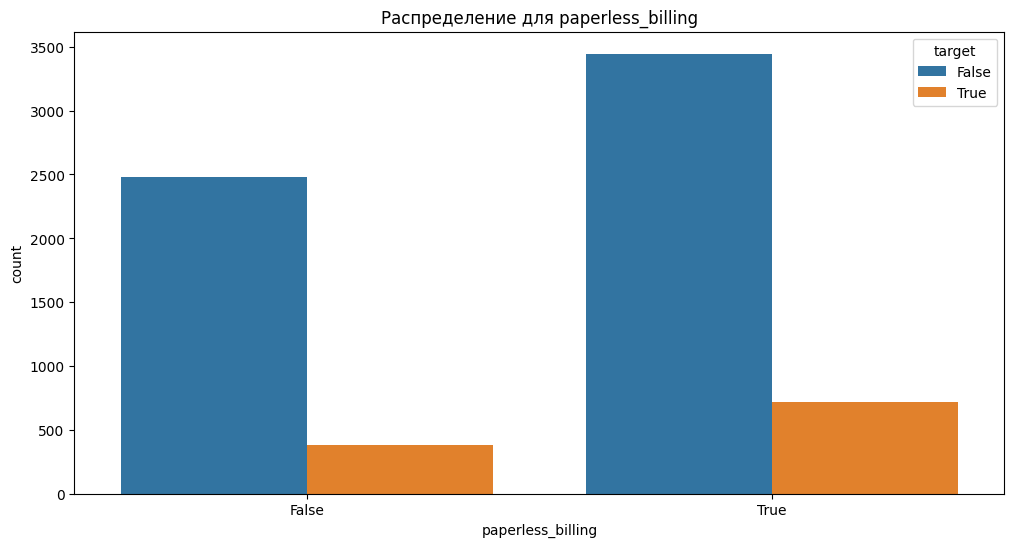

In [39]:
cat_col_plot('paperless_billing')

Булев.
Cильной зависимости для целевой не прослеживается.

payment_method
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64

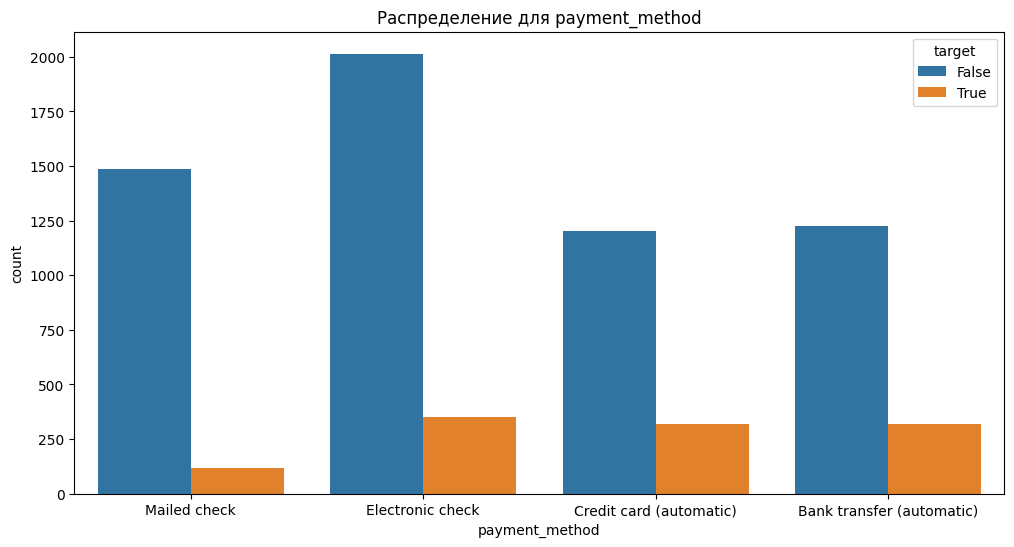

In [40]:
cat_col_plot('payment_method')

4 варианта, можно сделать one-hot.
Cильной зависимости для целевой не прослеживается.

is_male
True     3549
False    3483
Name: count, dtype: int64

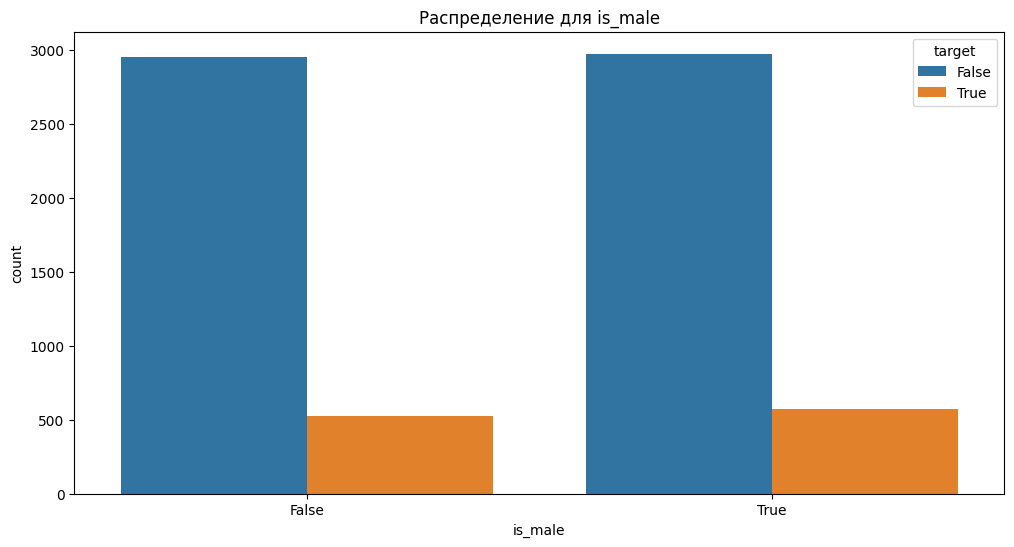

In [41]:
cat_col_plot('is_male')

Булев.
Cильной зависимости для целевой не прослеживается.

senior_citizen
False    5890
True     1142
Name: count, dtype: int64

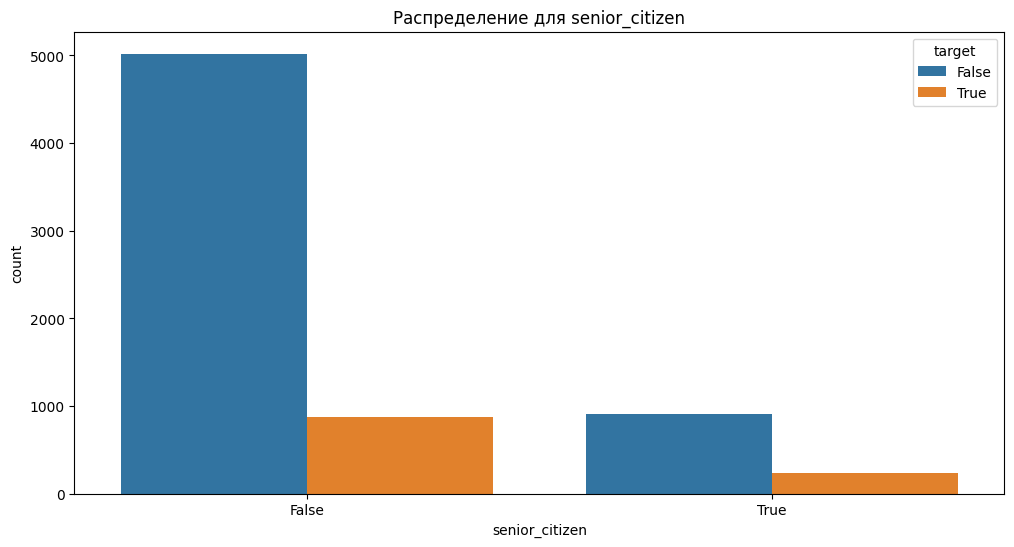

In [42]:
cat_col_plot('senior_citizen')

Булев. Cильной зависимости для целевой не прослеживается.

partner
False    3639
True     3393
Name: count, dtype: int64

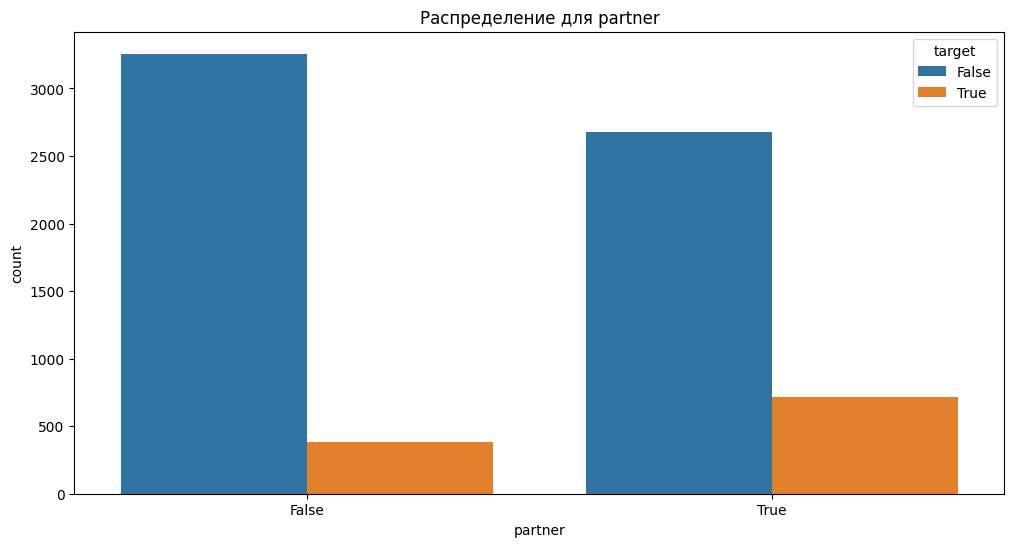

In [43]:
cat_col_plot('partner')

Булев. Похоже, люди в браке чаще разрывают договор.

dependents
False    4933
True     2099
Name: count, dtype: int64

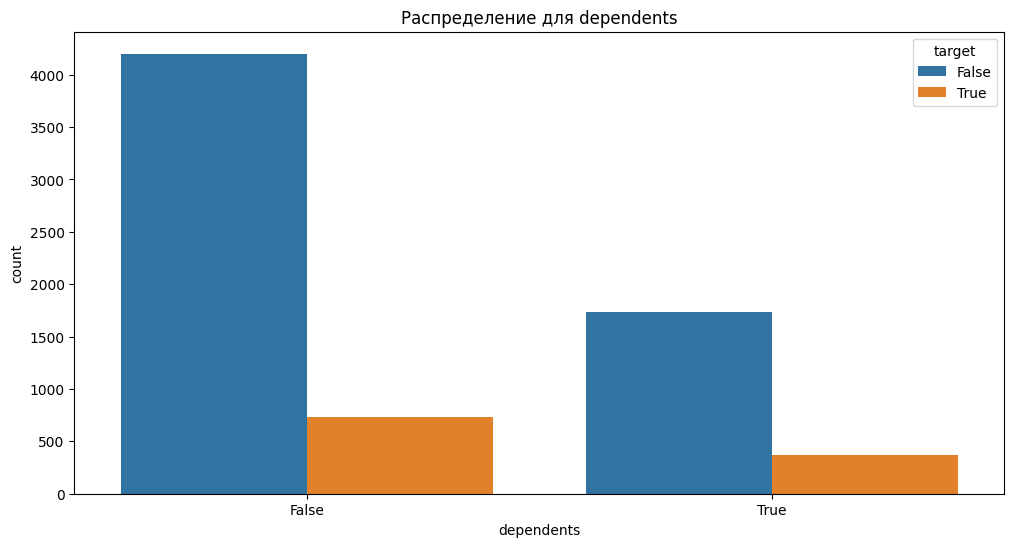

In [44]:
cat_col_plot('dependents')

Булев. Cильной зависимости для целевой не прослеживается.

internet_service
Fiber optic    3096
DSL            2416
n/a            1520
Name: count, dtype: int64

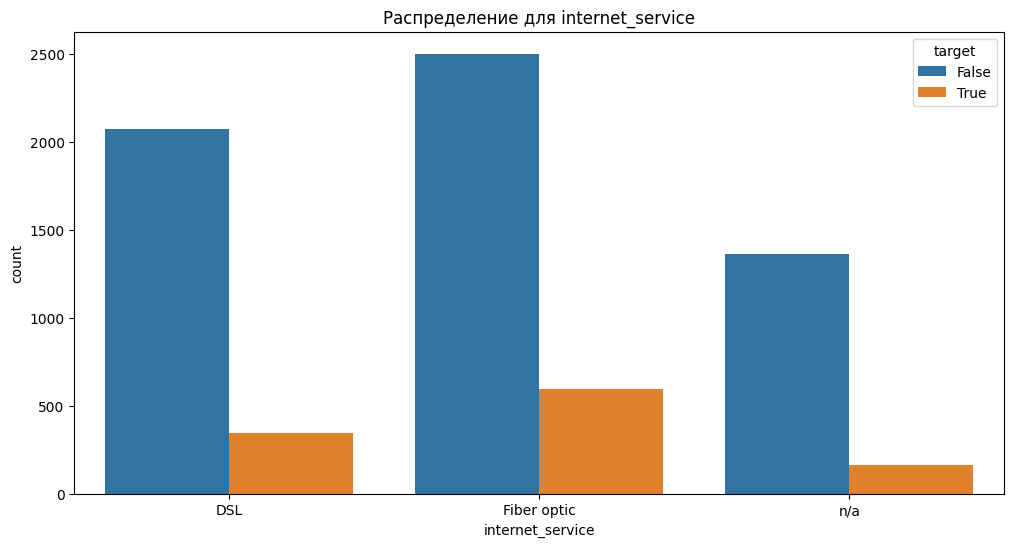

In [45]:
cat_col_plot('internet_service')

3 варианта, можно сделать one-hot. Cильной зависимости для целевой не прослеживается.

online_security
False    5017
True     2015
Name: count, dtype: int64

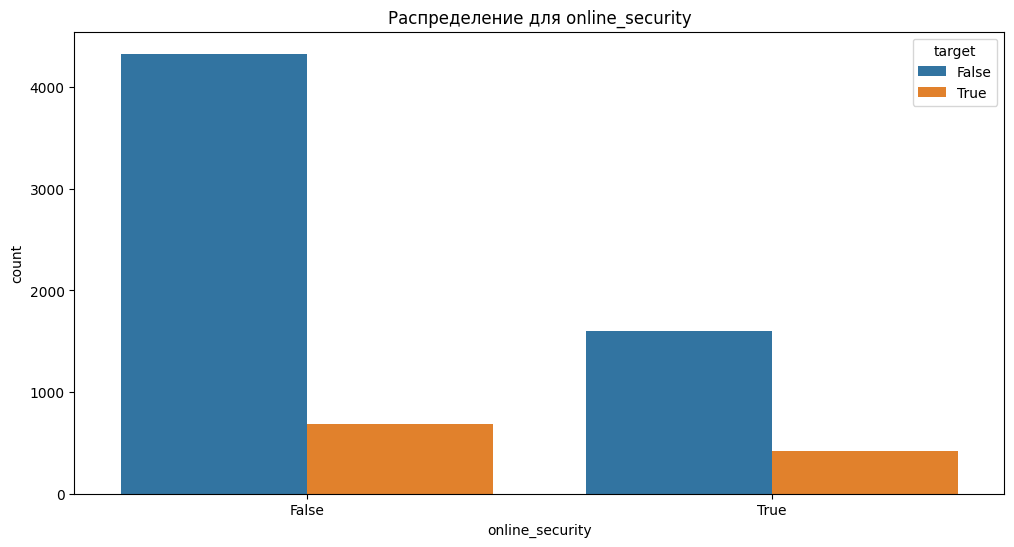

In [46]:
cat_col_plot('online_security')

Булев. Cильной зависимости для целевой не прослеживается.

online_backup
False    4607
True     2425
Name: count, dtype: int64

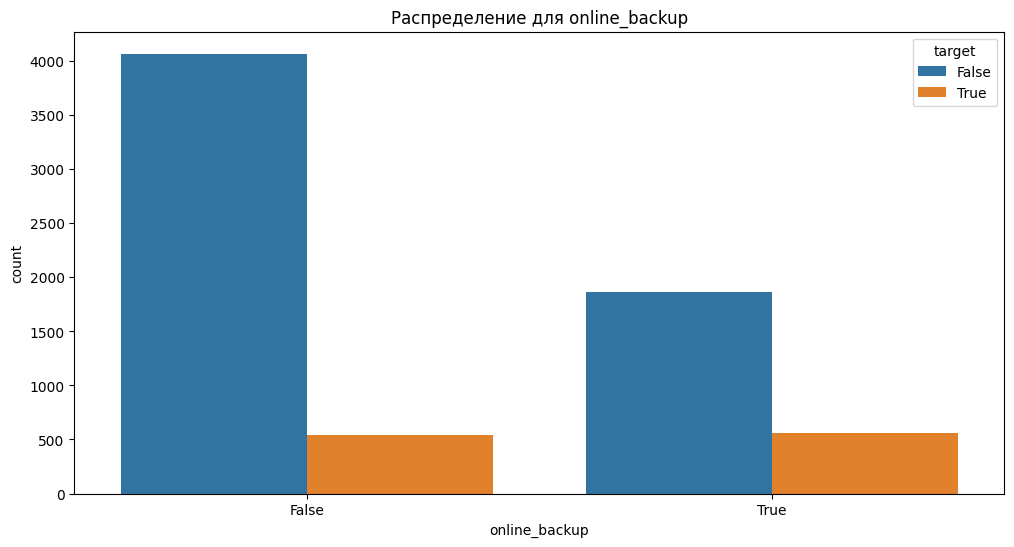

In [47]:
cat_col_plot('online_backup')

3 варианта, можно сделать one-hot. Люди, которые пользуются онлайн бэкапом, часто уходят - может, с ним были проблемы

device_protection
False    4614
True     2418
Name: count, dtype: int64

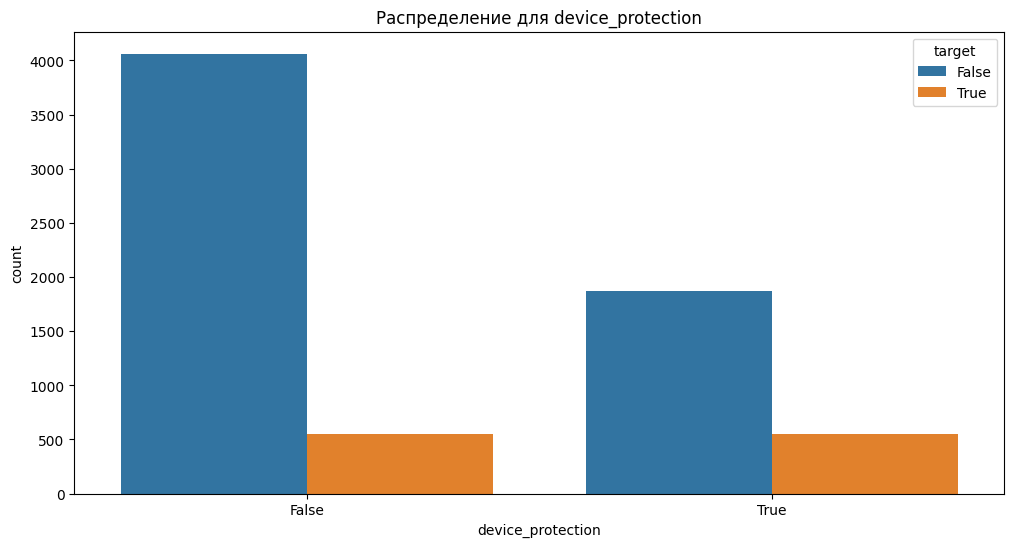

In [48]:
cat_col_plot('device_protection')

3 варианта, можно сделать one-hot. Люди, которые пользуются антивирусом, часто уходят - может, с ним тоже были проблемы

tech_support
False    4992
True     2040
Name: count, dtype: int64

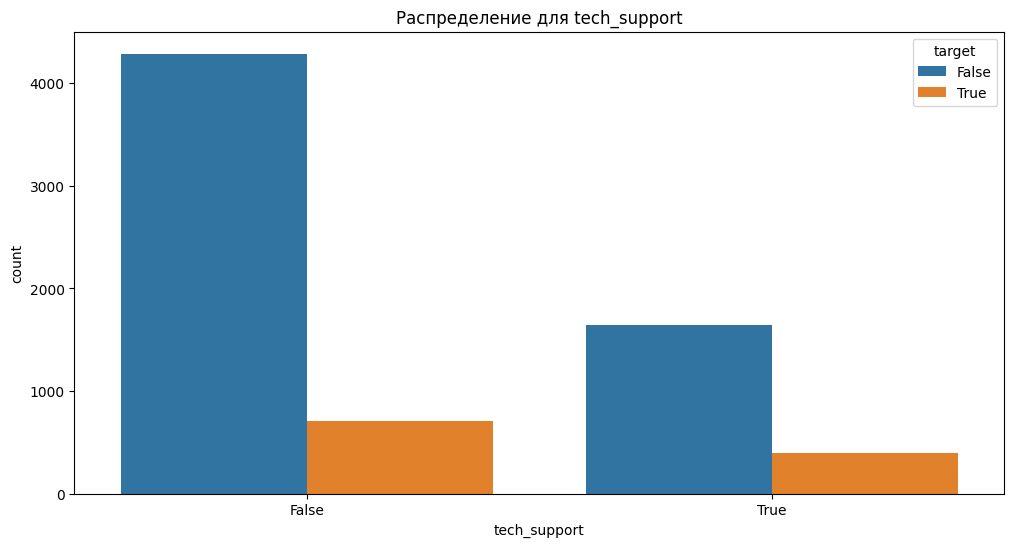

In [49]:
cat_col_plot('tech_support')

3 варианта, можно сделать one-hot. Cильной зависимости для целевой не прослеживается.

streaming_tv
False    4329
True     2703
Name: count, dtype: int64

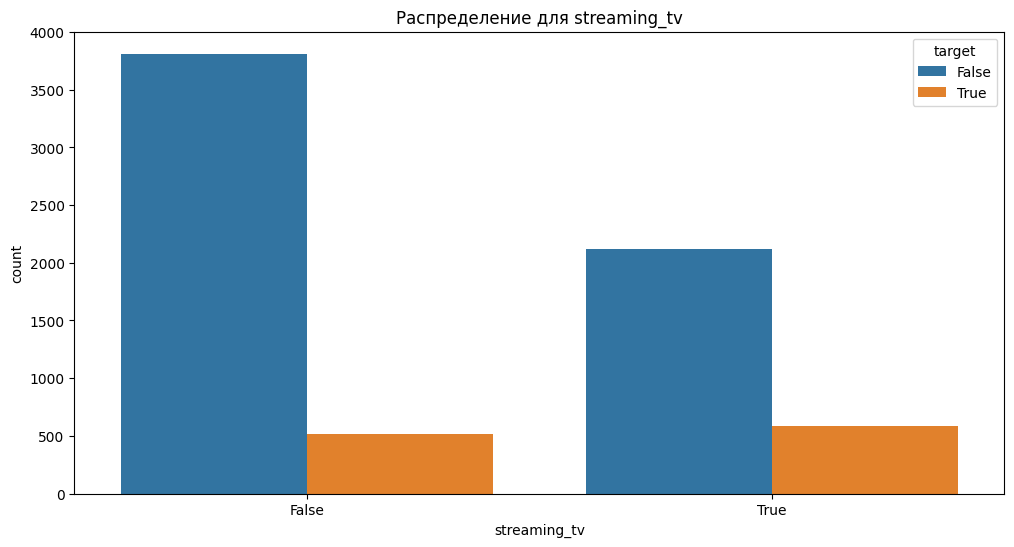

In [50]:
cat_col_plot('streaming_tv')

3 варианта, можно сделать one-hot. Люди, которые пользуются онлайн ТВ, часто уходят - может, и с ним тоже были проблемы

streaming_movies
False    4301
True     2731
Name: count, dtype: int64

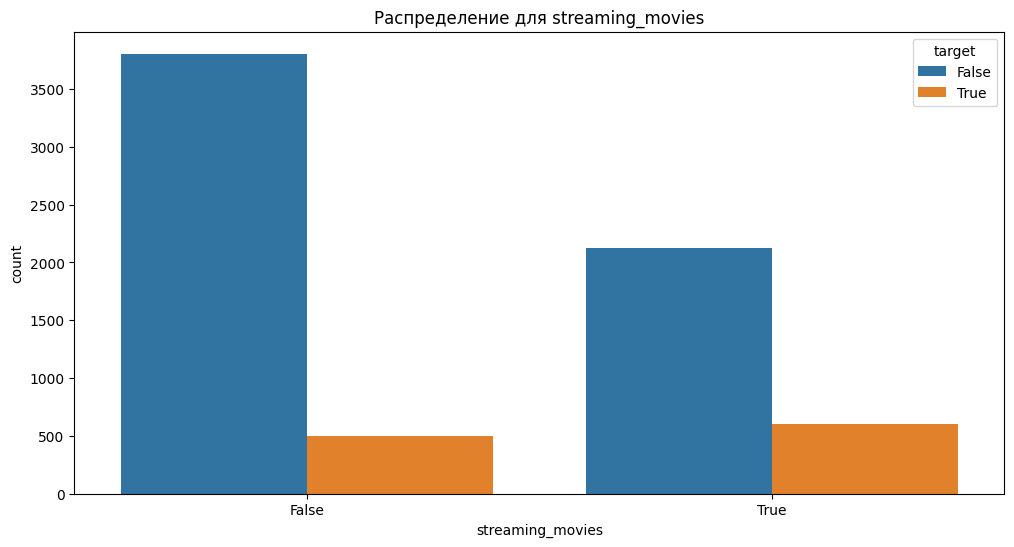

In [51]:
cat_col_plot('streaming_movies')

3 варианта, можно сделать one-hot. Ситация похожа на ТВ, бэкап и антивирус.

multiple_lines
False    4065
True     2967
Name: count, dtype: int64

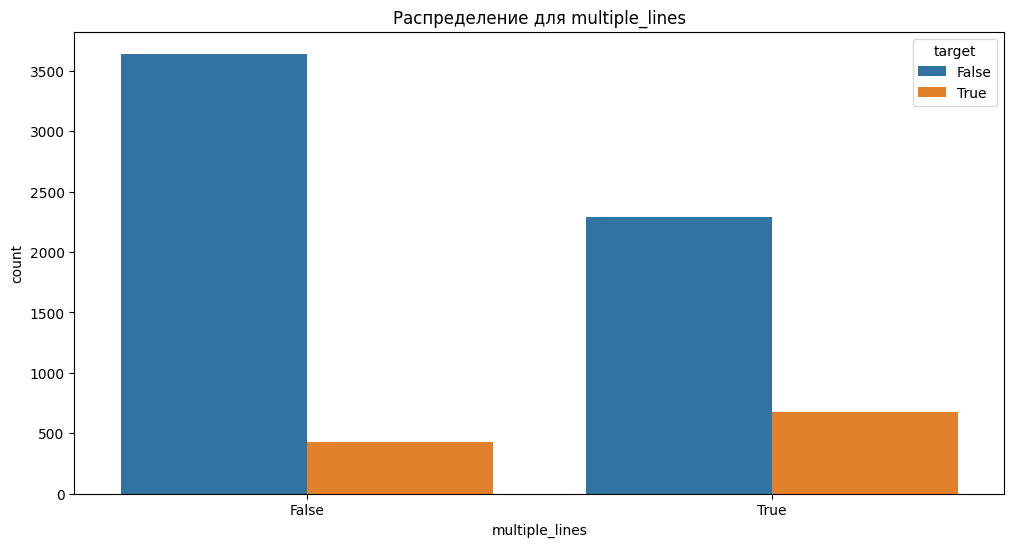

In [52]:
cat_col_plot('multiple_lines')

3 варианта, можно сделать one-hot. Люди, которые пользуются нескольким линиям, часто уходят - может, и с этим сервисом опять же были проблемы

### Численные признаки

In [53]:
def num_col_plot(
    x
):
    display(data[x].describe())
    plt.figure(figsize=(12, 6))
    sns.histplot(data=data, x=x, hue='target')
    plt.title(f'Распределение для {data[x].name}')
    plt.show()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64

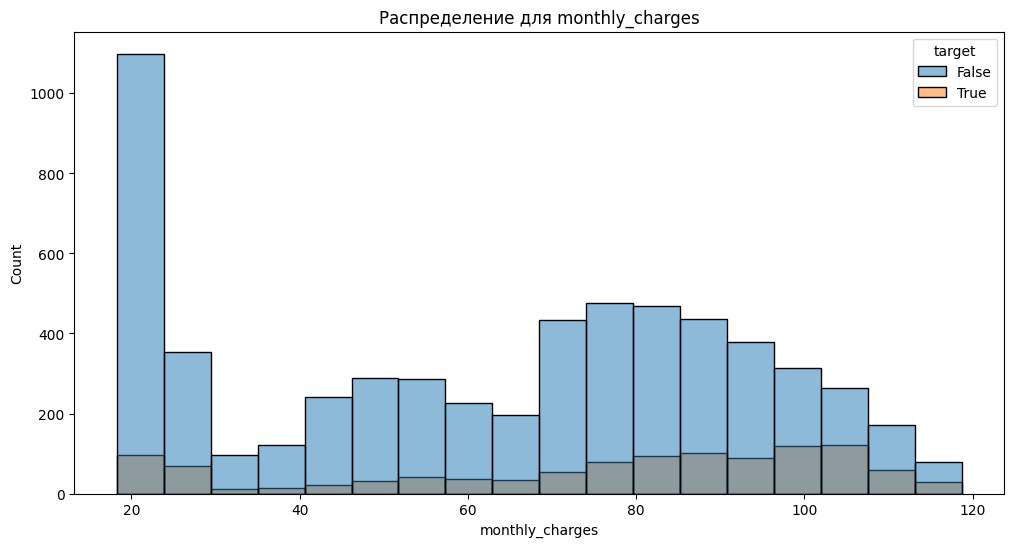

In [54]:
num_col_plot('monthly_charges')

Разброс от 18 до 119. Можно нормализовать. Можно отметить, что клиенты с небольшим ежемесячным платежом реже уходят по сравнению с остальными. Веротяно, те, кто платят больше, более требовательны к качеству услуг.

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

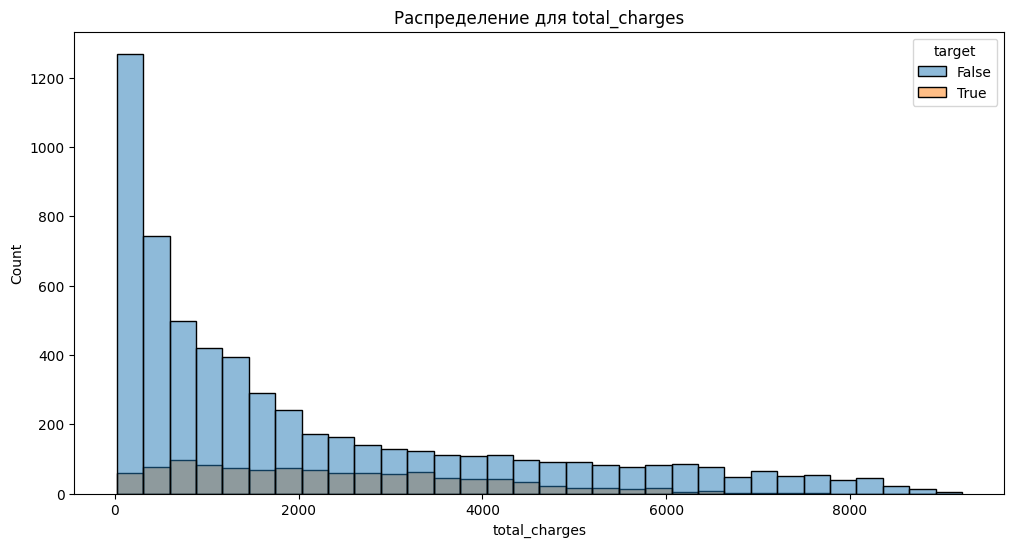

In [55]:
num_col_plot('total_charges')

Разброс от 19 до 9200. Можно нормализовать. Можно отметить, что клиенты, заплатившие немного в сумме, реже уходят по сравнению с остальными. Вероятно, часто уходят те, у кого накопилось недовольство за больший период.

count    7.032000e+03
mean     1.295944e+06
std      9.831438e+05
min      4.032000e+04
25%      3.974400e+05
50%      1.095840e+06
75%      2.103840e+06
max      3.332160e+06
Name: contract_duration, dtype: float64

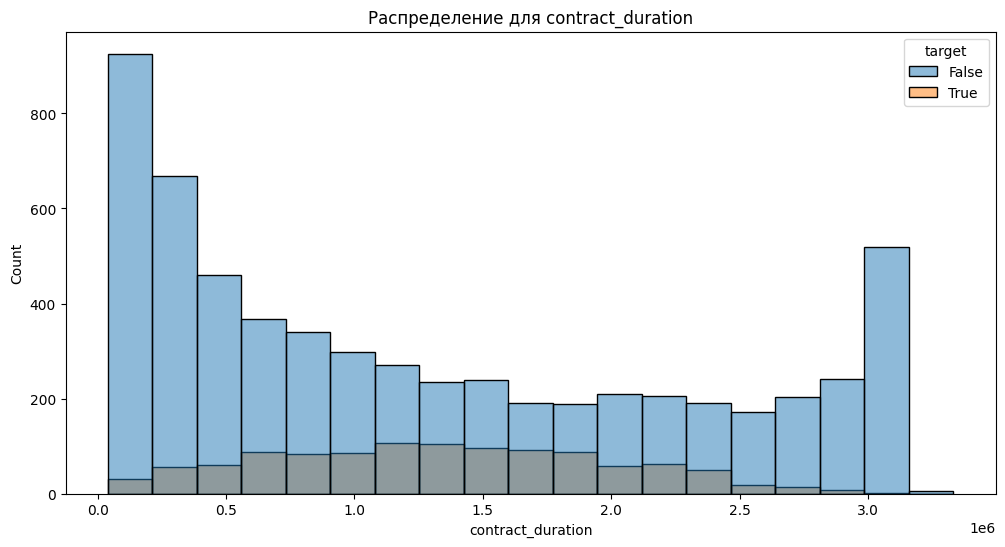

In [56]:
num_col_plot('contract_duration')

Хорошо видно, что между contract_duration и целевой величиной есть сложная нелинейная связь.

### Корреляционный анализ

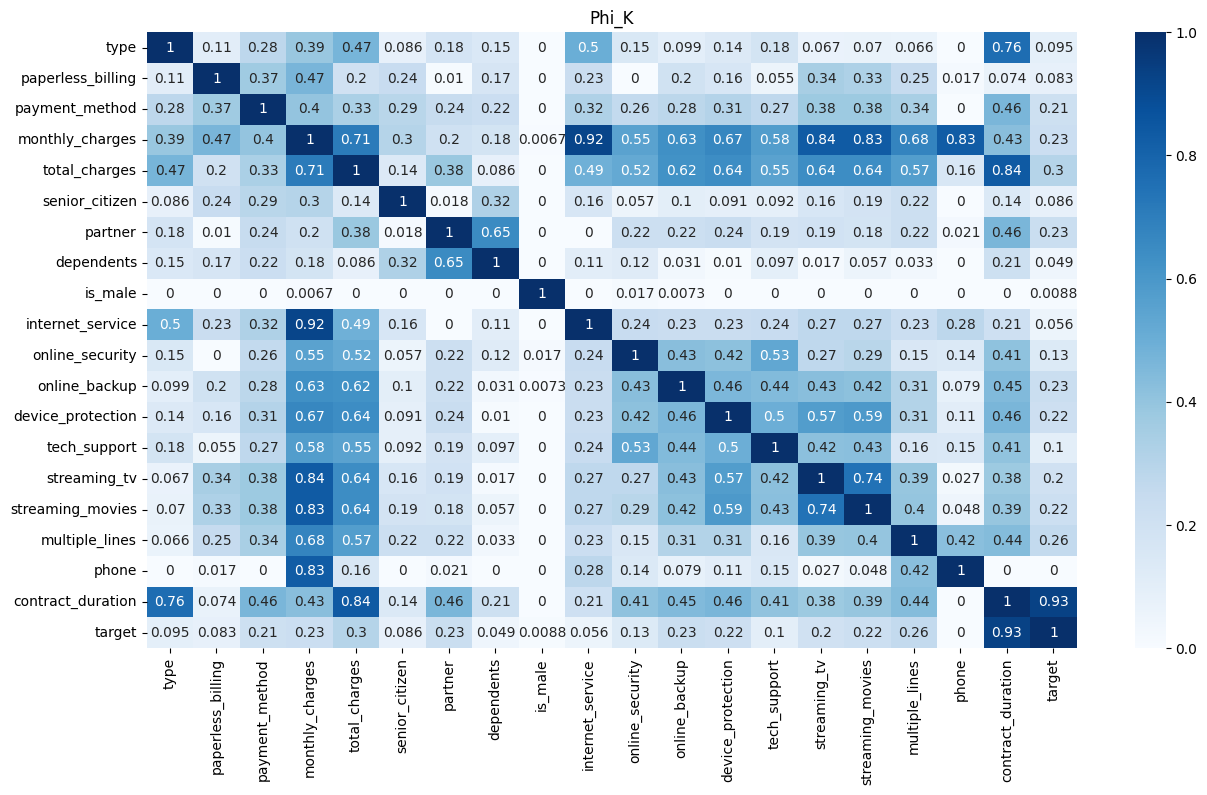

In [57]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    data.drop(
        ['end_date', 'begin_date', 'gender'], 
        axis=1
    ).phik_matrix(
        interval_cols=['monthly_charges', 'total_charges']
    ), 
    annot=True, 
    cmap='Blues'
)
plt.title('Phi_K')
plt.show()

Наиболее сильная корреляция между целевой и признаком наблюдается для сгенеррированного contract_duration. 
Для других признаков таже есть связь, но куда более слабая.
Есть корреляция между некоторыми признаками - риск мультиколиннеарости присутствует.

### Итог
- Проанализированы распределения численных и категориальных признаков, выявлены связи с целевой переменной
- Проведен корреляционный анализ с помощью PhiK

## Подготовка данных

In [58]:
# колонки с признаками
# уберём даты (есть длительность) и пол (есть булев is_male)
bool_cols = [
    'is_male',
    'phone',
    'multiple_lines',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]

num_cols = [
    'monthly_charges',
    'total_charges',
    'contract_duration' # новое v1
]


ohe_cols = [
    'type',
    'payment_method',
    'internet_service'
]

In [59]:
data_train, data_test = train_test_split(
    data,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=data.target
)

### Булевы признаки

In [60]:
X_train = data_train[bool_cols].copy()
X_test = data_test[bool_cols].copy()

X_train.shape, X_test.shape

((5274, 9), (1758, 9))

### One-hot

In [61]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoder.fit(data_train[ohe_cols])
cols = encoder.get_feature_names_out()

X_train[cols] = encoder.transform(data_train[ohe_cols])
X_test[cols] = encoder.transform(data_test[ohe_cols])

X_train.shape, X_test.shape

((5274, 16), (1758, 16))

### StandardScaler

In [62]:
scaler = StandardScaler()

scaler.fit(data_train[num_cols])

X_train[num_cols] = scaler.transform(data_train[num_cols])
X_test[num_cols] = scaler.transform(data_test[num_cols])

X_train.shape, X_test.shape

((5274, 19), (1758, 19))

### Target

In [63]:
y_train = data_train['target']
y_test = data_test['target']

y_train.shape, y_test.shape

((5274,), (1758,))

### Итог
- Обучающая и тестовые выборки готовы

## Обучение моделей

### Пайплайн

In [64]:
pipe = Pipeline(
    [
        ('model', DummyClassifier(random_state=RANDOM_STATE))
    ]
)

In [65]:
param_grid = [
    
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__C': [0.1, 1., 10.]
    },
    
    {
        'model': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__kernel': ['linear', 'poly', 'rbf']
    },

    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': [6, 8, 10]
    },

    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': [6, 8, 10]
    },
    
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'model__max_depth': [6, 8, 10]
    }
]

### Обучение

In [66]:
grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=1,
    verbose=2
)

In [67]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=0.1; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=0.1; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=0.1; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=0.1; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=0.1; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=1.0; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=1.0; total time=   0.0s
[CV] END model=LogisticRegression(class_weight='balanced', random_state=300625), model__C=1.0; total time=   0.0s
[CV] END model=LogisticRegr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        DummyClassifier(random_state=300625))]),
             n_jobs=1,
             param_grid=[{'model': [LogisticRegression(class_weight='balanced',
                                                       random_state=300625)],
                          'model__C': [0.1, 1.0, 10.0]},
                         {'model': [SVC(class_weight='balanced',
                                        random_state=300625)],
                          'model__kernel': ['linear', 'poly', 'rbf']},
                         {'model': [DecisionTreeClassifier(class_weight='balanced',
                                                           random_state=300625)],
                          'model__max_depth': [6, 8, 10]},
                         {'model': [RandomForestClassifier(class_weight='balanced',
                                                           random_state=300625)],
                          'model__max_depth': [6, 8, 10]},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x7946b8509de0>],
                          'model__max_depth': [6, 8, 10]}],
             scoring='roc_auc', verbose=2)

In [68]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__kernel,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,1.559028,0.047915,0.003796,0.000280,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,6.0,{'model': <catboost.core.CatBoostClassifier ob...,0.891876,0.882417,0.868097,0.879220,0.858397,0.876001,0.011627,1
13,2.807977,0.037147,0.003784,0.000109,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,8.0,{'model': <catboost.core.CatBoostClassifier ob...,0.887484,0.878720,0.862159,0.871468,0.857013,0.871369,0.010997,2
14,7.441353,0.090684,0.005342,0.000107,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,10.0,{'model': <catboost.core.CatBoostClassifier ob...,0.857807,0.861307,0.842070,0.850082,0.837086,0.849671,0.009142,3
10,0.204919,0.001366,0.010364,0.000173,RandomForestClassifier(class_weight='balanced'...,NaN,NaN,8.0,{'model': RandomForestClassifier(class_weight=...,0.794767,0.818240,0.797160,0.822038,0.792985,0.805038,0.012459,4
9,0.179382,0.000793,0.009553,0.000076,RandomForestClassifier(class_weight='balanced'...,NaN,NaN,6.0,{'model': RandomForestClassifier(class_weight=...,0.792012,0.819394,0.798621,0.817397,0.795259,0.804536,0.011524,5
5,0.259412,0.002386,0.084871,0.000606,"SVC(class_weight='balanced', random_state=300625)",NaN,rbf,NaN,"{'model': SVC(class_weight='balanced', random_...",0.803643,0.793517,0.810902,0.805061,0.806613,0.803947,0.005755,6
11,0.228211,0.001755,0.011470,0.000372,RandomForestClassifier(class_weight='balanced'...,NaN,NaN,10.0,{'model': RandomForestClassifier(class_weight=...,0.792366,0.812142,0.785403,0.816323,0.789310,0.799109,0.012613,7
4,0.223443,0.004486,0.033420,0.000245,"SVC(class_weight='balanced', random_state=300625)",NaN,poly,NaN,"{'model': SVC(class_weight='balanced', random_...",0.799687,0.788281,0.800232,0.797884,0.804506,0.798118,0.005377,8
6,0.008902,0.000145,0.002181,0.000035,DecisionTreeClassifier(class_weight='balanced'...,NaN,NaN,6.0,{'model': DecisionTreeClassifier(class_weight=...,0.740017,0.766895,0.761965,0.809628,0.774885,0.770678,0.022650,9
1,0.010127,0.000538,0.002107,0.000089,"LogisticRegression(class_weight='balanced', ra...",1.0,NaN,NaN,{'model': LogisticRegression(class_weight='bal...,0.739414,0.747783,0.757263,0.776966,0.764979,0.757281,0.013086,10


### Итог

С использованием GridSearchCV были опробованы 5 моделей с соответствующими наборами гиперпараметров.
Было установлено, что наилучшие результаты показывают CatBoostClassifier с максимальной глубиной 6 и 8 и SVC с полиномиальным и радиальным ядром.
Наилучшие результаты показал вариант градиентного бустинга из CatBoost с максимальной глубиной 6. 
Вероятно, так достигается наименьший эффект переобучения.

## Выбор и тестирование лучшей модели
Возьмём в качестве модели ту, что лучше всего показала себя в GridSearchCV, и посмотрим на метрики

In [70]:
y_test_pred = grid.predict(X_test)
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]

print(f'accuracy на тестовой: {accuracy_score(y_test, y_test_pred):.3f}')
print(f'roc_auc на тестовой: {roc_auc_score(y_test, y_test_pred_proba):.3f}')

accuracy на тестовой: 0.897
roc_auc на тестовой: 0.913


### Итог

Метрика roc_auc на тестовой выборке ощутимо выше целевого значения 0.85 и близка к значениям, полученным на обучающей.

## Анализ важности признаков

In [71]:
# сделаем shap на небольшом сэмпле
sample = shap.sample(X_train, 100, random_state=RANDOM_STATE)
explainer = shap.KernelExplainer(grid.predict, sample)
shap_values = explainer(sample)

  0%|          | 0/100 [00:00<?, ?it/s]

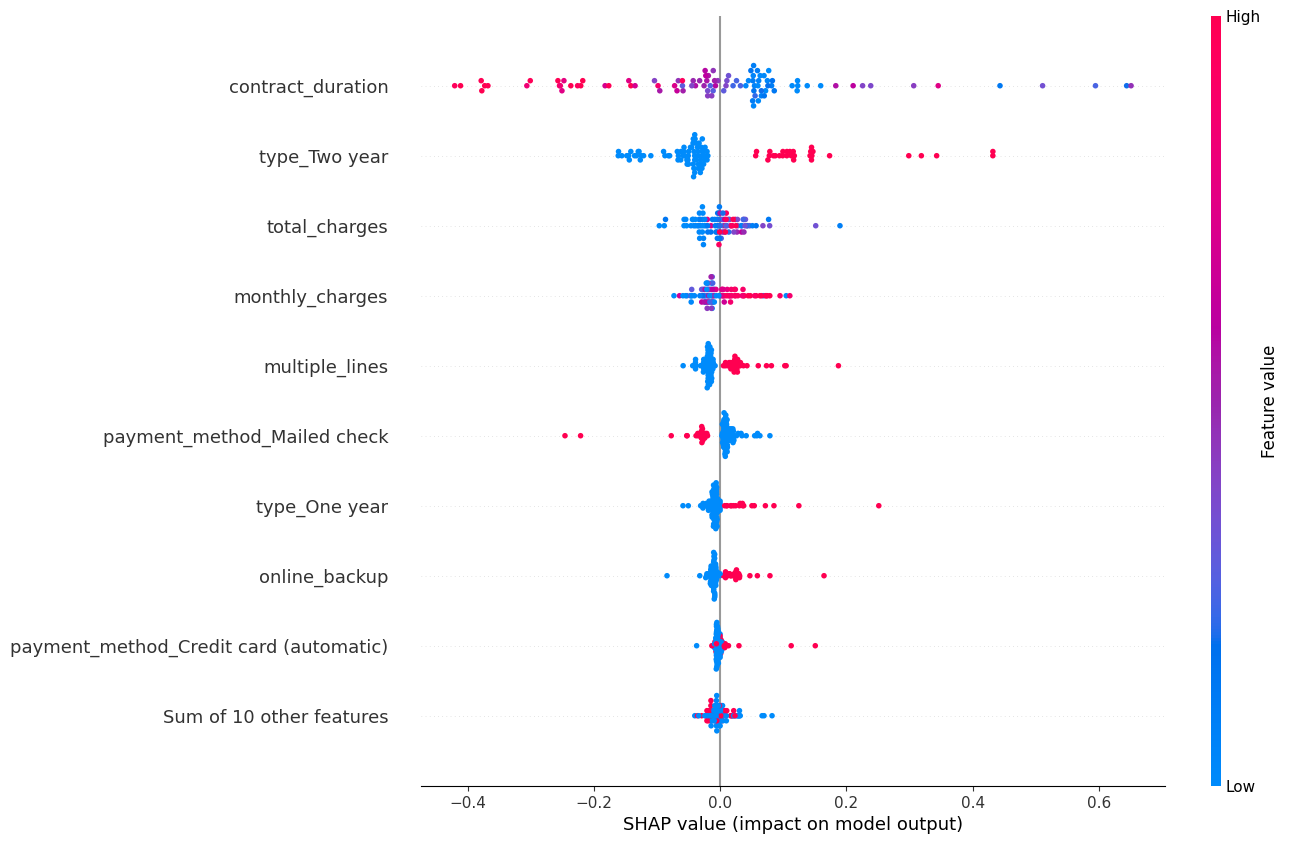

In [72]:
shap.plots.beeswarm(shap_values, plot_size=(12, 10))

### Итог

Подтверждаются некоторые наблюдения, отмеченные в рамках исследовательского анализа. 
В частности, что чаще уходят те клиенты, которые:
- оплачивают услуги раз в год / два года
- больше платят в месяц
- пользуются услугами multiple_lines, online_backup и online_security

Также можно отметить, что видна сложная связь между целевой и contract_duration - сильно маленькие и сильно большие величины толкают ответ в класс 1

## Выводы и рекомендации Заказчику

Результаты и выводы:
- Данные загружены, обработаны и объединены в общий датафрейм
- Обработаны пропуски в исходных данных и в объединённом датафрейме
- Проведен иследовательский анализ данных, выявлены закономерности для целевой, исследована корреляция признаков с целевой и между собой
- Данные разделены на обучающую и тестовую выборки, закодированы и отмасштабированы для корректной работы любых моделей
- С использованием GridSearchCV найдена лучшая модель и соответствующие гиперпараметры. Целевые значения метрики на обучающей выборке достигнуты, проверка на тестовой показала адекватность предсказываемых результатов. 

Заказчику хочется порекомендовать обратить особой внимание на клиентов, у которых оплата услуг проходит раз в год / два года, а также на тех, кто пользуется дополнительными услугами (multiple_lines, online_backup и online_security)